# Design Considerations

## Part 1: Identify FIVE design decisions for this system.
Argue for how this design decision is significant to the system, and your plans to analyze this design. If needed, use the dataset provided to you.

### 1. Class-Specific IOU Thresholds
One factor to consider in designing this object detection system is the IOU threshold, which is used in the Non-Maximal Suppression step of the interference service. This threshold is also used in determining whether or not a predicted bounding box is correctly labeled. If the threshold is high, that means a large degree of overlap would be required to consider two bounding boxes as detecting the same object. This would be useful for classes where objects are frequently close together, like cardboard boxes. However, for objects that are more spread out like cars or forklifts, a lower IOU threshold may be better to eliminate redundant detections during the NMS process. To decide on IOU thresholds per class, we can perform an experimental analysis where we test various IOU thresholds (e.g. 0.3, 0.5, 0.7) and determine calculate model metrics using a validation set partitioned by class, and determine which IOU produces the best performance for each class. Since precision and recall are sensitive to IOU changes, the performance metric used would be the mean average precision, which would also help account for imbalanced classes.

### 2. Image Size
A second factor to consider is the image size. The input images must be resized so that they are all the same size and can be ingested by the model. Larger images contain more information and therefore ideally lead to more accurate detections; however, they're more computationally expensive to process. Smaller images can be processed quicker, but have less information and may lead to less accurate predictions. Another experimental analysis can be done to decide on an appropriate image size. A validation set can be used to calculate the model performance (again using mAP) multiples times, each time processing the images using a different image size. We can then plot images size vs mAP, and if we track processing speed, we can plot image size vs. speed, and find an image size that balances both speed and performance.

### 3. Frame Skipping
Skipping frames can reduce the computational time required to process a video, which can be especially useful for real-time applications like a robotic platform in a warehouse. If we only process one out of every five frames for example, we could process a video in 1/5 of the time it would take to process every frame. The speed and computational efficency comes at the cost of decreased information. Since we're not processing some frames, we're not seeing some data, which may lead worse model performance. To find a balance between speed and model performance, we can analyze a video with known detections and run our prediction process on the video, skipping various numbers of frames. We can keep track of procesing time as well as model performance, using the mAP (mean average precision) metric, and then plot both of these values vs. the number of frames skipped. By plotting these 2 relationships, we can identify the number of frames to skip to achieve good performance and speed.

### 4. Detection Ranking Criteria for Hard Negative Mining
Hard negative mining is used to find samples that the model performed the worst on, so they can be used to retrain the model on these difficult input examples. The criteria for ranking the worst performing inputs can be based on confidence score or loss, which is an important design decision to make. The confidence score directly reflects a model's certainty about its prediction, so it's easy to interpret since high-confidence scores with false positives likely indicate that they'll significantly impact model performance. This allows the model to be retrained with the most problematic errors directly. Alternatively, the loss score coprehensively addresses the errors since it accounts for both classification and localization errors, and ensures that both low and high confidence errors are addressed. The loss score can be further tuned by adjusting the lambda parameter that determines how much weight to put on the localization errors vs classification errors. To analyze this factor, an experimental test could be run by using a validation set to calculate the model performance using mAP, running multiple times and retraining using a different ranking criteria for hard negative mining. The criteria that results in the model with best performance should be chosen.

### 5. Dataset Size
Dataset size is another design factor to consider. Increased training dataset size potentially could result in a better performing model if the datast include good, diverse data that accurately represents test/real world data. However, lack of diversity or balance in the training set could be more likely to lead to overfitting with a larger dataset size. Additionally, larger datasets take longer to train and process than smaller datasets. Another experimental analysis can be done to decide on an appropriate dataset size. A validation set can be used to train the model and calculate the model performance (again using mAP) multiples times, each time processing the images using a different dataset size. We can then plot dataset size vs mAP, and if we track processing speed, we can plot dataset size vs. speed, and find a dataset size that balances both speed and performance. Speed will be important in cases where errors are being made so retraining is required, which ideally should be efficient so that the robot is not out of use for too long.

## Part 2: Analyze TWO out of the five design decisions. Add the results of your analysis.

### Image Size
The first analysis done is comparing the time it takes to process different image sizes when processing and predicting a set of 1000 images. The processing of each image is timed, and the mean image processing time per image size is plotted vs image size. The results indicate that an image size of 416 may work well since the mean processing time decreases at 416, before increasing again for an image size of 624. A secondary analysis on model performance (using mAP) can be done to help further identify a suitable image size.

Successfully loaded model...


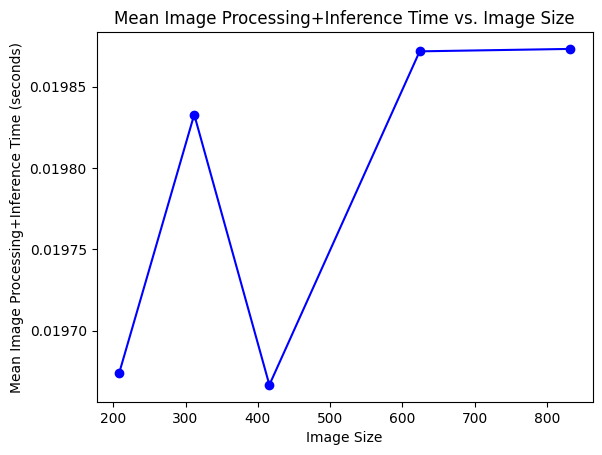

In [35]:
import sys
sys.path.insert(1,'../')
import os
import cv2
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from src.inference import object_detection
from src.inference import non_maximal_suppression

# Load class names from file
with open('../logistics/_darknet.labels', 'r') as f:
    classNames = [line.strip() for line in f.readlines()]

# Load training label files
trainImgs = [f'../logistics/{f}' for f in os.listdir('../logistics') if f[-4:] == '.jpg']

# Load model
cfg_path = "../yolo_resources/yolov4-tiny-logistics_size_416_1.cfg"
weights_path = "../yolo_resources/models/yolov4-tiny-logistics_size_416_1.weights"
names_path = "../yolo_resources/logistics.names"
detector = object_detection.YOLOObjectDetector(cfg_path, weights_path, names_path)

# Set up NMS
score_threshold = .5
iou_threshold = .4
nms = non_maximal_suppression.NMS(score_threshold, iou_threshold)

# Run prediction on different image sizes
imgSizes = [208, 312, 416, 624, 832]
meanTimes = []
stdTimes = []
allTimes = np.zeros([5,1000])
# Select a random tample of 1000 of the training images
sampleSet = random.sample(trainImgs, 1000)
for i in range(len(imgSizes)):
    imgSize = imgSizes[i]
    # Run detection for each image in the sample set, keeping track of time
    for f in range(len(sampleSet)):
        frame = cv2.imread(sampleSet[f])
        start = time.time()
        if frame.shape[0] != imgSize and frame.shape[1] != imgSize:
            frame = cv2.resize(frame, (imgSize,imgSize))
        output = detector.predict(frame)
        detections = detector.process_output(output)
        filteredDetections = nms.filter(detections)
        end = time.time()
        allTimes[i,f] = end-start

# Calculate average time per image and plot vs image size
meanTimes = np.mean(allTimes,axis=1)
plt.plot(imgSizes,meanTimes,'bo-')
plt.title('Mean Image Processing+Inference Time vs. Image Size')
plt.xlabel('Image Size')
plt.ylabel('Mean Image Processing+Inference Time (seconds)')
plt.show()

### Dataset Size
The next analysis done is comparing the time it takes to process different dataset sizes when processing and predicting a set of images. The processing of each dataset is timed, and the processing time is plotted vs dataset size. The results indicate that a positive linear relationship between dataset size and processing time, so depending on the system requirements for timing, a dataset size can be chosen accordingly. A secondary analysis on model performance (using mAP) can be done to help further identify a suitable dataset size.

Text(0, 0.5, 'Dataset Processing+Inference Time (seconds)')

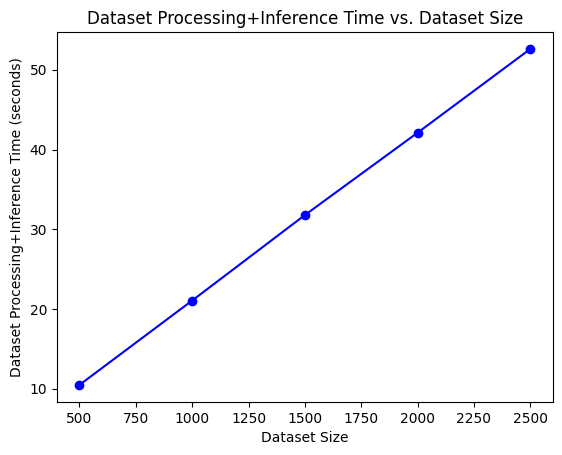

In [23]:
# Initialize dataset sizes
datasetSizes = [500, 1000, 1500, 2000, 2500]
imgSize = 416
times = []
# Predict all images in a random sample of training set for each dataset size
for datasetSize in datasetSizes:
    start = time.time()
    # generate random sample from training set
    sampleSet = random.sample(trainImgs, datasetSize)
    # Run prediction on each image in the training set
    for f in range(len(sampleSet)):
        frame = cv2.imread(sampleSet[f])
        if frame.shape[0] != imgSize and frame.shape[1] != imgSize:
            frame = cv2.resize(frame, (imgSize,imgSize))
        output = detector.predict(frame)
        detections = detector.process_output(output)
        filteredDetections = nms.filter(detections)
    end = time.time()
    # Keep track of time taken to process the dataset
    times.append(end-start)

# Plot process time vs dataset size
plt.plot(datasetSizes,times,'bo-')
plt.title('Dataset Processing+Inference Time vs. Dataset Size')
plt.xlabel('Dataset Size')
plt.ylabel('Dataset Processing+Inference Time (seconds)')
plt.show()